### Option Pricing

In this notebook I provide three models that can be used to calculate a call or put stock option price: the Binomial model, the Black Scholes model, and the Monte Carlo model. I also briefly introduce the QuantLib python package, which can be used to calculate an option price.

In [1]:
# imports
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt
from math import *
from scipy.stats import norm
import datetime
import QuantLib as ql 

Set up the spot price, volatility, risk free rate, strike price, and time to maturity that will be used as parameters to the option pricing models

In [2]:
# spot price
S = 50

# volatility
sigma = .40

# risk free rate
r = .10

# strike price
K= 50

# T is time to maturity annulised
calculationDate = datetime.datetime(2020, 1, 15)
maturityDate = datetime.datetime(2020, 6, 14)
daysToMaturity = (maturityDate - calculationDate).days
T = daysToMaturity / 365
print ("Number of days to maturity is {}" .format(daysToMaturity))

# Enum for option type
class OptionType(Enum):
    Call = 1
    Put = 2

Number of days to maturity is 151


note: while the number of days to maturity is not used in the models presented in this notebook, the number of days can be used with online calculators such as http://www.option-price.com/index.phpm. This is the online calculator that I used to verify the option prices given by the models.

### Cox, Ross and Rubinstein (CRR) Binomial model

The Binomial option pricing model is a risk-neutral model used to value path-independent options. Under the binomial model, the current value of an option equals the present value of the probability-weighted future payoffs from the options. The binomial model breaks down the time to expiration into intervals, which provides the opportunity to configure different rates and probabilities for each interval. This flexibility to reconfigure parameters at each time interval allows the binomial model to price path-independent options, such as American or Bermudian options.  

In [3]:
def CRR(S,sigma,r,T,K,N,optionType = OptionType.Call,dividend=0):
    # h is the length of each time interval
    h = T/N

    # u is size of up movement
    u = exp(sigma * sqrt(h))
    d = 1/u
    a = exp((r-dividend) * h)

    # p is probability of an up movmement
    p = (a - d) / (u - d)

    # matrix to hold expected value of option at each node in binomial tree
    tree = np.zeros((N+1,N+1))

    # get the expected value of the option for each node at time T
    for j in range(N+1):
        # get the value of S at time T 
        ST = S * (u**(N-j)) * (d**j)

        if optionType == OptionType.Put:
            tree[(j,N)] = max(K - ST,0)
        else:
            # default to call
            tree[(j,N)] = max(ST - K,0)

    # work backwards from expected value at T to get expected value of option at T0
    for i in range(N-1,-1,-1):
        for j in range(i+1):

            # need to also discount average
            tree[(j,i)] = exp(-r * h) * ( (p * tree[(j,i+1)]) + ((1 - p) * tree[(j+1,i+1)] ))

    return tree[(0,0)]


# N is number of intervals in Binomial tree
N = 250
CRRPrice = CRR(S,sigma,r,T,K,N,OptionType.Call)

print ("Price calculated using Cox, Ross and Rubinstein (CRR) Binomial model is {}" .format(round(CRRPrice,4)))

Price calculated using Cox, Ross and Rubinstein (CRR) Binomial model is 6.0865


### Black Scholes model
The Black Scholes model, also known as the Black Scholes Merton (BSM) model, is a closed-form formula that can be used to price European call and put options. The  Black Scholes Merton model is the most efficient model to use for valuing path-independent options, however, as the path is defined, the Black Scholes model can only be used to price European options; the model cannot be used to price  American-style options which can be exercised prior to the expiration date.

In [4]:
def BlackScholesModel(S,sigma,r,T,K,optionType,dividend=0):
    d1 = (log(S/K)+((r-dividend)+sigma*sigma/2.)*T)/(sigma*sqrt(T))
    d2 = d1-sigma*sqrt(T)
    if optionType==OptionType.Call:
        return S*exp(-dividend*T)*norm.cdf(d1)-K*exp(-r*T)*norm.cdf(d2)
    else:
        return K*exp(-r*T)*norm.cdf(-d2)-S*exp(-dividend*T)*norm.cdf(-d1)

bsmPrice = BlackScholesModel(S,sigma,r,T,K,OptionType.Call)

print ("Price calculated using Black Scholes model is {}" .format(round(bsmPrice,4)))

Price calculated using Black Scholes model is 6.0916


Although the original Black Scholes model of 1973 did not incorporate dividends, the calculation can easily be added to the model. 

In [5]:
dividend_rate = 0.15
print("CRR price with dividend rate of {}% is {:.2f}" 
      .format( dividend_rate * 100, CRR(S,sigma,r,T,K,N,OptionType.Call,dividend_rate)))
print("BSM price with dividend rate of {}% is {:.2f}" 
      .format( dividend_rate * 100, BlackScholesModel(S,sigma,r,T,K,OptionType.Call,dividend_rate)))

# reset the dividend rate
dividend_rate =  0.0

CRR price with dividend rate of 15.0% is 4.38
BSM price with dividend rate of 15.0% is 4.38


### BSM as a special case of Binomial model
The BSM is the a limiting case of the Binomial model. As the number of intervals in the Binomial model approaches infinity, the Binomial model price converges on the BSM price.

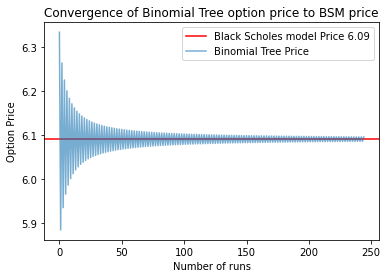

In [6]:
optionPrices = []
for n in range(5,250):
    optionPrices.insert(n, CRR(S,sigma,r,T,K,n,OptionType.Call))

plt.title("Convergence of Binomial Tree option price to BSM price")
plt.xlabel("Number of runs")
plt.ylabel("Option Price")
plt.axhline(y=bsmPrice, color='r', linestyle='-',label="Black Scholes model Price {}" .format(round( bsmPrice,2)))
plt.plot(optionPrices,alpha=.6,label="Binomial Tree Price " )
plt.legend()

plt.show()

### Monte Carlo model

As with the CRR and BSM models, the price of the option is its discounted expected value; The process behind the Monte Carlo method is to generate a large number of feasible random paths that the stock price can take, calculate the payoff at maturity date for each path, the option price is then the discounted average payoff. <br>Ito's Lemma process is used to generate the random price paths.

In [7]:
def MonteCarlo(S,sigma,r,T,K,N,optionType = OptionType.Call):
    # stochastic element of Ito's lemma process 
    W = np.random.normal(size=(N))

    # array of expected prices of S at time T
    expectedST = S * np.exp((r - 0.5 * sigma**2) * T + sigma * sqrt(T) * W)

    if optionType == OptionType.Put:
        payoffs = np.maximum(S - expectedST,0)
    else:
        # default to option type call
        payoffs = np.maximum(expectedST - S,0)

    # option price is present value of mean of expected payoffs
    return np.mean(payoffs) * np.exp(-r*T)

N= 10000000 # number of simulations

ms_price = MonteCarlo(S,sigma,r,T,K,N,OptionType.Call)

print ("Price calculated using Monte Carlo is {}" .format(round(ms_price,4)))


Price calculated using Monte Carlo is 6.0881


### Convergence of Monte Carlo option price to BSM price
The Monte Carlo method is computational expensive and the element of randomness introduced in the Monte Carlo method means that it does not converge on the BSM price as cleanly as the Binomial Tree/ BSM option price convergence.
<br>An advantage of the Monte Carlo method is that the source of uncertainty can be changed. In the implementation above the source of uncertainty modelled is the Stock price S, however for a bond option the source of uncertainty may be the the interest rate, which can be applied using a Monte Carlo model. 

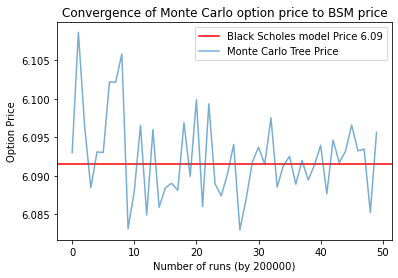

In [8]:
optionPrices = []
step = 200000

for n in range(step,N+1, step):
    optionPrices.insert(n, MonteCarlo(S,sigma,r,T,K,n,OptionType.Call))

plt.title("Convergence of Monte Carlo option price to BSM price")
plt.xlabel("Number of runs (by {})" .format(step))
plt.ylabel("Option Price")
plt.axhline(y=bsmPrice, color='r', linestyle='-',label="Black Scholes model Price {}" .format(round( bsmPrice,2)))
plt.plot(optionPrices,alpha=.6,label="Monte Carlo Tree Price")
plt.legend()

plt.show()

### QuantLib package
QuantLib is an open-source library for quantitative finance, and the QuantLib python package provides models for pricing options. QuantLib provides an number of advantages over using the textbook implementations discussed so far:
Real world implementations need to consider such things as Calendars and day count conventions used, which the QuantLib package can account for. The backend of QuantLib is written in C++ and so will be faster than a model written purely in Python. The QuantLib calculation also provides additional information such as the option greeks.<br>
Below is the boilerplate code for calculating an option price of a European call using the QuantLib Black Scholes model.

In [9]:
# option data
option_type = ql.Option.Call
day_count  = ql.Actual365Fixed() 
calendar =  ql.UnitedStates()

qlCalculationDate = ql.Date(calculationDate.day,calculationDate.month,calculationDate.year)
ql.Settings.instance().evaluationDate = qlCalculationDate

# construct the European Option
payoff = ql.PlainVanillaPayoff(option_type, K)

qlMaturityDate =   ql.Date(maturityDate.day,maturityDate.month,maturityDate.year)
exercise = ql.EuropeanExercise(qlMaturityDate)
european_option = ql.VanillaOption(payoff, exercise)

spot_handle = ql.QuoteHandle(
    ql.SimpleQuote(S)
)
flat_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(qlCalculationDate, r, day_count)
)
dividend_yield = ql.YieldTermStructureHandle(
    ql.FlatForward(qlCalculationDate, dividend_rate, day_count)
)
flat_vol_ts = ql.BlackVolTermStructureHandle(
    ql.BlackConstantVol(qlCalculationDate, calendar, sigma, day_count)
)
bsm_process = ql.BlackScholesMertonProcess(spot_handle, 
                                           dividend_yield, 
                                           flat_ts, 
                                           flat_vol_ts)

european_option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))
bs_price = european_option.NPV()
print ("Price calculated using Quantlib is {}" .format(round(bs_price,4)))

print ("Delta: {}" .format(round(european_option.delta(),4)))
print ("Gamma: {}" .format(round(european_option.gamma(),4)))
print ("Theta: {}" .format(round(european_option.theta(),4)))
print ("Vega: {}" .format(round(european_option.vega(),4)))
print ("Rho: {}" .format(round(european_option.rho(),4)))

Price calculated using Quantlib is 6.0916
Delta: 0.6139
Gamma: 0.0297
Theta: -8.4083
Vega: 12.3036
Rho: 10.1779
